# ARIMA-SARIMAX
- Data Source: [Monthly fuel consumption in Spain](https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/consumos-combustibles-mensual.csv)
- Tutorial: [ARIMA and SARIMAX models with Python](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html?fbclid=IwAR1Ex6o8zhlrQFXAbrfWvBu5c563JZVC8HBmPiGoNtO5xzcQOhQqQgiOCJY)

In [76]:
# Libraries
# ======================================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Data Exploration

In [34]:
df = pd.read_csv('../data/consumos-combustibles-mensual.csv', index_col='Fecha', parse_dates=['Fecha'])\
       .rename(columns={'Gasolinas':'litters'})['litters']
df.index.name = 'date' # rename index col 'Fecha' to 'date'
df = df.loc[:'1990-01-01'] # filter up to 1990-01-01

In [35]:
df.index.max()

Timestamp('1990-01-01 00:00:00')

In [36]:
# downsample to only month start
df = df.asfreq('MS') 

In [37]:
df.head() # only sample with each month start

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
Freq: MS, Name: litters, dtype: float64

In [38]:
# Train-test dates
# ======================================================================================
end_train = '1980-01-01 23:59:59'
print(f"Train dates : {df.index.min()} --- {df.loc[:end_train].index.max()}  (n={len(df.loc[:end_train])})")
print(f"Test dates  : {df.loc[end_train:].index.min()} --- {df.loc[:].index.max()}  (n={len(df.loc[end_train:])})")
data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


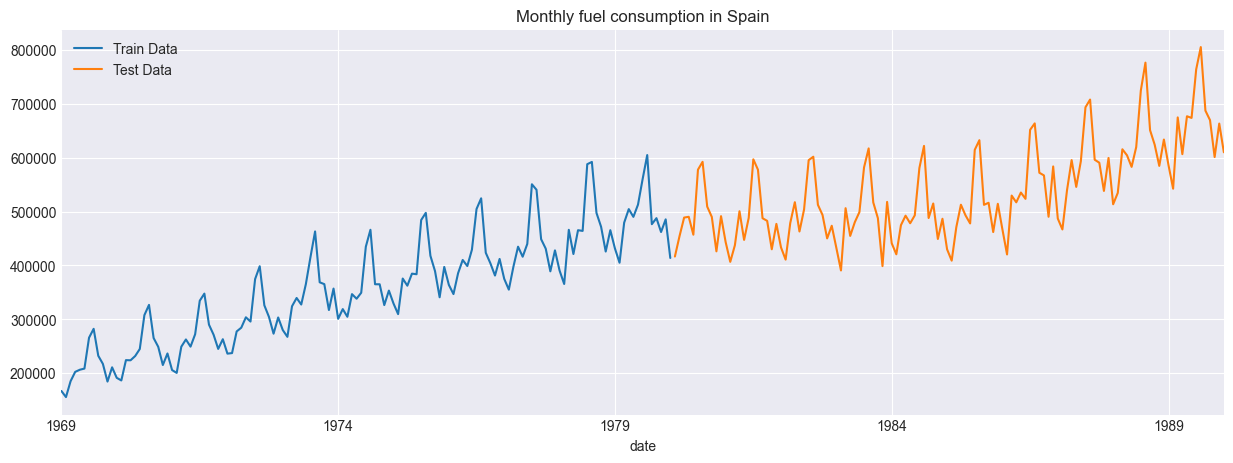

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
data_train.plot(ax=ax, label='Train Data')
data_test.plot(ax=ax, label='Test Data')
ax.legend()
ax.set_title('Monthly fuel consumption in Spain')
plt.show()

In [40]:
data_train.head()

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
Freq: MS, Name: litters, dtype: float64

## EDA

### Stationarity and Differentiation
- Before fitting an ARIMA model to time series data, it is important to conduct an exploratory analysis to determine:
    - `Stationarity` Stationarity means that the statistical properties (mean, variance...) remain constant over time, 
        - Time series with trends or seasonality are NOT stationary.
        - Stationary test: Augmented Dickey-Fuller (ADF) or the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to assess stationarity
        - If non-stationarity is found, the series should be differenced until stationarity is achieved.
            - This analysis helps to determine the optimal value of the parameter $d$
    -  `Autocorrelation` to identify potential lag relationships between data points.
        - Visual analysis: autocorrelation and partial autocorrelation functions (ACF and PACF)
            - This analysis provides insight into determining appropriate autoregressive (AR) and moving average (MA) terms ($p$
  and  $q$) for the ARIMA model.
    - `Seasonal Decomposition` in cases where seasonality is suspected, decomposing the series into trend, seasonal, and residual components using techniques such as moving averages or seasonal time series decomposition (STL) can reveal hidden patterns and help identify seasonality. 
        - This analysis helps to determine the optimal values of the parameters  $P$, $D$, $Q$ and $m$

#### Stationary
- Example of non-stationary: the positive trend in the series, indicating a steady increase over time. Consequently, the mean of the series increases over time, confirming its non-stationarity.
- Differencing is one of the easiest techniques to detrend a time series:
    - First difference: $X_t - X_{t-1}$
        - A new series is generated where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.
    - The original time series is subjected to both first and second-order differencing and statistical tests are applied to determine whether stationarity is achieved.

##### Augmented Dickey-Fuller test
- **Augmented Dickey-Fuller** test takes as its null hypothesis that the time series has a **unit root** - a characteristic of non-stationary time series. Conversely, the alternative hypothesis (under which the null hypothesis is rejected) is that the series is stationary.
  - Null Hypothesis ($H_0$): The series is not stationary or has a unit root.
  - Alternative hypothesis ($H_A$): The series is stationary with no unit root.
- **Rule**: the p-value obtained should be less than a specified significance level, often set at `0.05`, to reject this hypothesis.
  - `p-value > 0.05` Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
  - `p-value <= 0.05` Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
```Python
from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(df)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
```

##### Kwiatkowski-Phillips-Schmidt-Shin test (KPSS)

- The KPSS test checks if a time series is stationary around a mean or linear trend.
- **Rule**: small p-values (e.g., less than `0.05`) rejects the null hypothesis and suggest that differencing is required.

```Python
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(df)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
```

##### Rules of Thumb
- It's common to use both tests together to get a more comprehensive understanding of the stationarity properties of a time series.
```Python
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series.values)
    kpss_result = kpss(series.values)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
    
test_stationary(data_train)
# Test stationarity for original series
# -------------------------------------
# ADF Statistic : -0.44612980998227814, p-value: 0.9021071923942668
# KPSS Statistic: 2.2096370946978383, p-value: 0.01
```
- For ADF test: Since the `p-value=0.9 > 0.05`, so cant reject the null hypothesis (the data is non-stationary) &#8594; non-stationary
- For KPSS test: Since the `p-value=0.01 < 0.05`, so can reject the null hypothesis (the data is stationary) &#8594; non-stationary

```Python
data_diff_1 = data_train.diff().dropna()
test_stationary(data_diff_1)
# Test stationarity for differenced series (order=1)
# -------------------------------------
# ADF Statistic : -3.6417276900323285, p-value: 0.005011605002137147
# KPSS Statistic: 0.05268059379842924, p-value: 0.1
```
- After the first differencing, the time series is indeed stationary as both ADF and KPSS tests have confirmed
    - For ADF test: Since the `p-value=0.005 < 0.05`, so can reject the null hypothesis (the data is non-stationary) &#8594; stationary
    - For KPSS test: Since the `p-value=0.1 > 0.05`, so cannot reject the null hypothesis (the data is stationary) &#8594; stationary 
- Therefore, the most appropriate selection for the ARIMA parameter $d=1$.

In [41]:
data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

In [42]:
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series.values)
    kpss_result = kpss(series.values)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [43]:
print('\nTest stationarity for original series')
print('-------------------------------------')
check_stationarity(df)


Test stationarity for original series
-------------------------------------
ADF Statistic : -0.44613, p-value: 0.90211
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
KPSS Statistic: 2.20964, p-value: 0.01000
Non-stationary


- For ADF test: Since the `p-value=0.9 > 0.05`, so cant reject the null hypothesis (the data is non-stationary) &#8594; non-stationary
- For KPSS test: Since the `p-value=0.01 < 0.05`, so can reject the null hypothesis (the data is stationary) &#8594; non-stationary

In [44]:
print('\nTest stationarity for differenced series (order=1)')
print('-------------------------------------')
check_stationarity(data_diff_1)

print('\nTest stationarity for differenced series (order=2)')
print('-------------------------------------')
check_stationarity(data_diff_2)


Test stationarity for differenced series (order=1)
-------------------------------------
ADF Statistic : -3.64173, p-value: 0.00501
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
KPSS Statistic: 0.05268, p-value: 0.10000
Stationary

Test stationarity for differenced series (order=2)
-------------------------------------
ADF Statistic : -8.23394, p-value: 0.00000
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580
KPSS Statistic: 0.50000, p-value: 0.04167
Non-stationary


- After the first differencing, the time series is indeed stationary.
    - For ADF test: Since the `p-value=0.005 < 0.05`, so can reject the null hypothesis (the data is non-stationary) &#8594; stationary
    - For KPSS test: Since the `p-value=0.1 > 0.05`, so cannot reject the null hypothesis (the data is stationary) &#8594; stationary 
- Therefore, the most appropriate selection for the ARIMA parameter $𝑑=1$.



#### Autocorrelation Analysis
- Autocorrelation Function (ACF) helps in identifying the value of $q$ (lag in the moving average part)
- Partial Autocorrelation Function (PACF) assists in identifying the value of $p$ (lag in the autoregressive part).
- Conclusion: The difference between ACF and PACF is the inclusion or exclusion of indirect correlations in the calculation.
    - Note: If the **stationarity analysis** indicates that **differencing is required**, **subsequent analysis** should be conducted **using the differenced series**

##### Intuition
- Let $S_t$ is the average price of salmon this month
- $S_t$ or the average price of salmon this month be affected by $S_{t-1}$ 
- $S_t$ is also affected by the price 2 months ago $S_{t-2}$ in two different ways:
    - Directly: $S_{t-2}$ &#8594; $S_t$
    - In-directly: $S_{t-2}$ &#8594; $S_{t-1}$ &#8594; $S_t$
    - Hence, the correlation $corr(S_{t-2}, S_t)$ which captures both **direct & in-direct** impact of the price 2 months ago, $S_{t-2}$, on the current price $S_t$, is the `ACF`
- PACF only focus on the direct impact $S_{t-2}$ &#8594; $S_t$

##### Autocorrelation Function (ACF)
- The ACF calculates the correlation between a time series and its lagged values. 
- A sharp drop-off in the ACF after a few lags indicates that the data have a finite **auto-regressive** (tự hồi quy sử dụng thông tin từ các bước trước và tạo đầu ra tiếp theo) order. 
- The lag at which the ACF drops off provides an estimation of the value $q$
- Note: If the ACF displays a sinusoidal or damped sinusoidal pattern, it suggests seasonality is present and requires **consideration of seasonal orders** in addition to non-seasonal orders.

##### Partial Autocorrelation Function (PACF)

- The PACF measures the correlation between a lagged value and the current value of the time series, while accounting for the effect of the intermediate lags. 
- In the context of ARIMA modeling, if the PACF sharply cuts off after a certain lag, while the remaining values are within the confidence interval, it suggests an AR model of that order. 
- The lag, at which the PACF cuts off, gives an idea of the value of $p$.

##### How to determine Order of AR, MA, and ARMA Models with ACF & PACF
- Examples: Tails off (Geometric decay) & Cuts off after lag `k` patterns

Tails off            |  Cuts off
:-------------------------:|:-------------------------:
![](../assets/img/acf-tail-off.webp)  |  ![](../assets/img/pacf-cutoff.webp)

- To determine the order of the model, you can use the following table:

| | AR($p, q=0$) | MA($p=0, q$) | ARMA($p$, $q$) |
|-|-|-|-|
|ACF|Tails off (Geometric decay) | Significant at lag $q$ / Cuts off after lag $q$|Tails off (Geometric decay) |
|PACF| Significant at each lag $p$ / Cuts off after lag $p$|Tails off (Geometric decay) |Tails off (Geometric decay) |

##### Rules of Thumb
- If only the PACF cuts off after lag p (ACF tails off), one could start with an $AR(p)$ model.
- If only the ACF cuts off after lag q (PACF tails off), one could start with an $MA(q)$ model.
- For real life times series dataset, both ACF and PACF plots are not clear whether they are tailing off or cutting off, so AR & MA models are not practically used.
    - In fact, the model ARMA & ARIMA (with differencing) $ARIMA(p, d, q)$ are used more frequently by determine the combination of $p$, $q$ to get the better score of AIC and BIC.


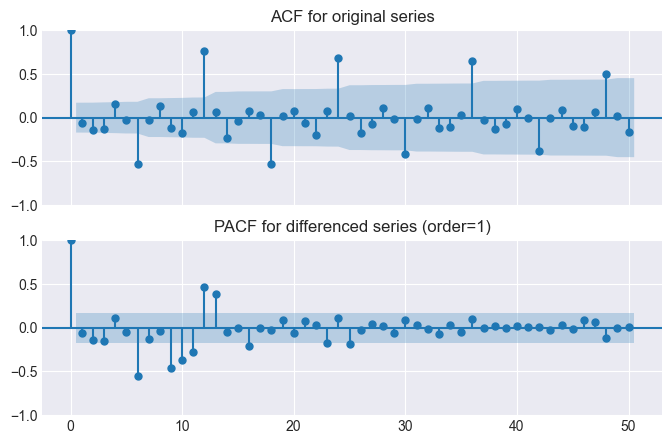

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)
# we’ll only look at 50 lags
plot_acf(data_diff_1, ax=axs[0], lags=50)
axs[0].set_title('ACF for original series')

plot_pacf(data_diff_1, ax=axs[1], lags=50)
axs[1].set_title('PACF for differenced series (order=1)');


- The ACF starts at a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.
    - We will ignore the long spike at lag 0.
- The blue area depicts the 95% confidence interval and is an indicator of the significance threshold. 
    - Anything within the blue area is statistically close to zero 
    - Anything outside the blue area is statistically non-zero, reveals the significant correlations.
- In this example, 
    - there are no clear tails-off or cut-offs, so we select 
        - $p=1$ and $q=1$
        - $p=6$ and $q=6$
    -  The ACF plot further supports the presence of seasonality, as significant peaks occur at lags corresponding to the 12-month intervals

#### Time Series Descomposition
- Time series decomposition involves breaking down the original time series into its underlying components, namely trend, seasonality, and residual (error) components.
- The decomposition can be either `additive` or `multiplicative`

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data_train, model='additive', extrapolate_trend='freq')
res_descompose_diff = seasonal_decompose(data_diff_1, model='additive',extrapolate_trend='freq')

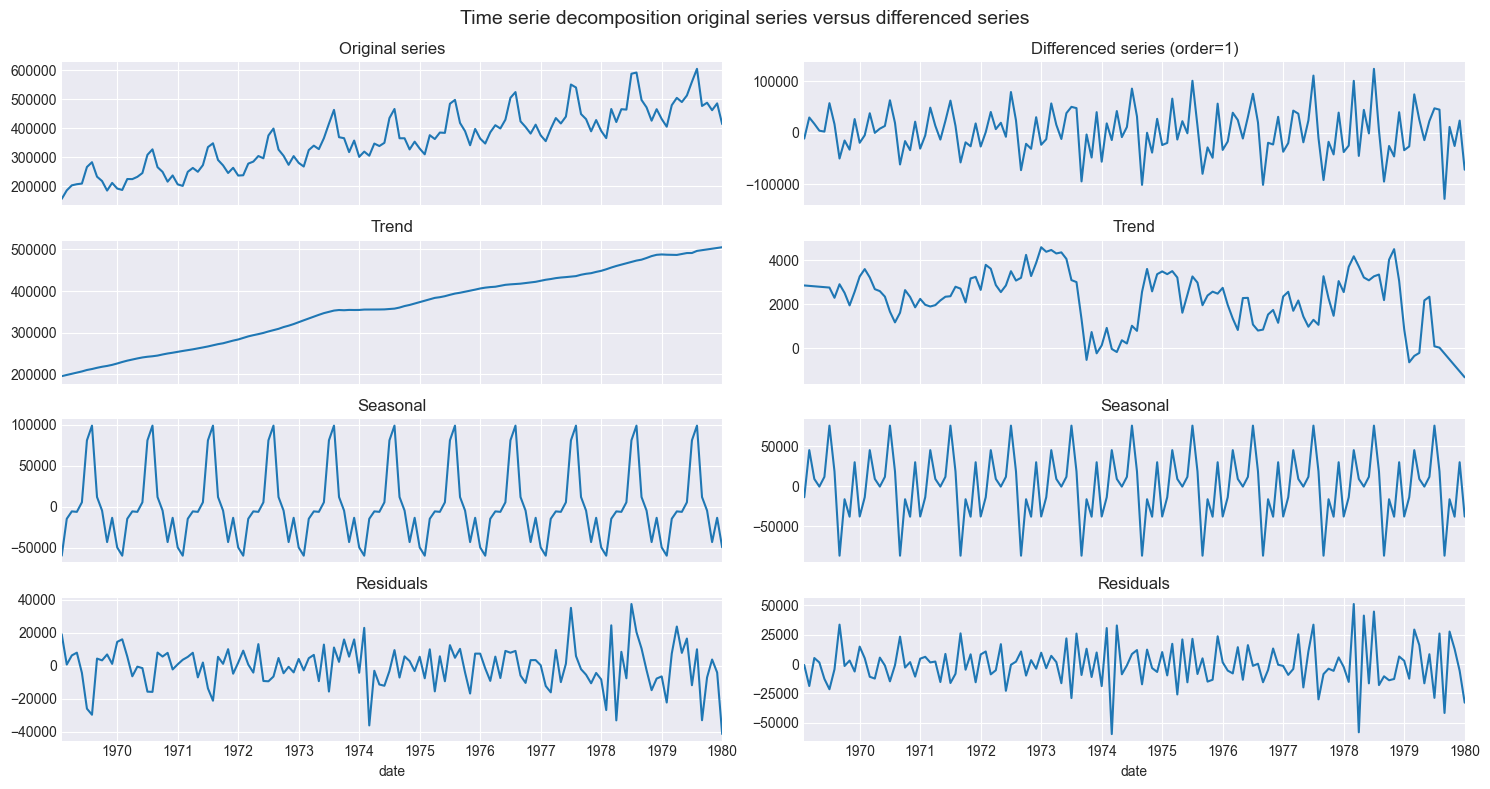

In [47]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 8), sharex=True)
for idx, res in enumerate([res_decompose, res_descompose_diff]):
    res.observed.plot(ax=ax[0, idx])
    ax[0, idx].set_title("Original series" if idx == 0 else "Differenced series (order=1)")
    res.trend.plot(ax=ax[1, idx])
    ax[1, idx].set_title("Trend")
    res.seasonal.plot(ax=ax[2, idx])
    ax[2, idx].set_title("Seasonal")
    res.resid.plot(ax=ax[3, idx])
    ax[3, idx].set_title("Residuals")
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

- Based on the time series decomposition, the recurring pattern every 12 months suggests an annual seasonality.
    - The ACF plot further supports the presence of seasonality, as significant peaks occur at lags corresponding to the 12-month intervals, confirming the idea of recurring patterns.

#### Conclusion for EDA
- Based on the results of the exploratory analysis, utilizing a combination of first-order differencing and seasonal differencing may be the most appropriate approach. 

In [48]:
# First order differentiation combined with seasonal differentiation
# ==============================================================================
data_diff_1_12 = data_train.diff().diff(12).dropna()
check_stationarity(data_diff_1_12)

ADF Statistic : -4.38746, p-value: 0.00031
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
KPSS Statistic: 0.06292, p-value: 0.10000
Stationary


## Model Training
- The model summary shows information about the fitting process:
    - **Model Fit Statistics**: This part includes several statistics that help you evaluate how well the model fits the data:
        - `Log-Likelihood`: A measure of how well the model explains the observed data. When fitting an ARIMA model, negative log-likelihood values will be encounter, with more negative values indicating a poorer fit to the data, and values closer to zero indicating a better fit.
        - `AIC` (Akaike Information Criterion): A goodness-of-fit metric that balances the fit of the model with its complexity. Lower AIC values are preferred.
        - `BIC` (Bayesian Information Criterion): Similar to AIC, but penalizes model complexity more. As with AIC, lower BIC values are better.
        - `HQIC` (Hannan-Quinn Information Criterion): Another model selection criterion, similar to AIC and BIC.
    - **Coefficients**: This table lists the estimated coefficients for the parameters of the model. It includes both autoregressive (AR) and moving average (MA) parameters, as well as any exogenous variables if they are included in the model. It also includes the standard errors associated with the estimated coefficients to indicate the uncertainty in the parameter estimates, their P-values, which are used to assess the significance of each coefficient, and the 95% confidence interval.
    - **Model diagnostics**: This section provides information about the residuals (the differences between the observed values (training values) and their predicted values from the model):
        - Ljung-Box test: A test for autocorrelation in the residuals.
        - Jarque-Bera test: A test of the normality of the residuals.
        - Skewness and kurtosis: Measures of the shape of the distribution of the residuals.

### `statsmodels`'s ARIMA, SARIMAX 

In [49]:
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [71]:
model = SARIMAX(endog=data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            litters   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Thu, 11 Apr 2024   AIC                           2722.103
Time:                                    15:44:35   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.3e+32. Standard errors may be unstable.
"""

In [73]:
# Prediction
# ==============================================================================
predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
predictions_statsmodels.head()

1980-02-01    407504.056928
1980-03-01    473997.245813
1980-04-01    489983.091484
1980-05-01    485517.462865
1980-06-01    504445.207333
Freq: MS, Name: predictions_statsmodels, dtype: float64

MAE: 37141.037


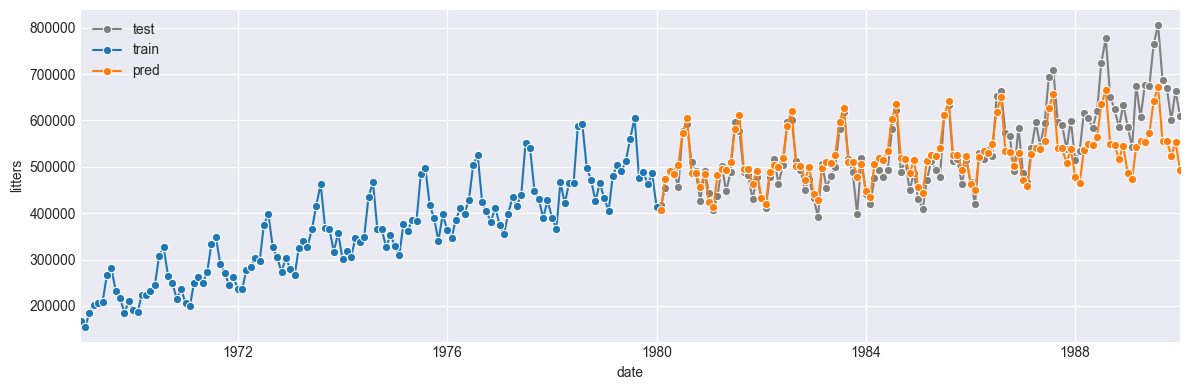

In [83]:
def eval_model(data_train, data_test, predictions):
    print(f"MAE: {mean_absolute_error(data_test, predictions):.3f}")
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.lineplot(x=data_test.index, y=data_test, marker='o', label='test', color='grey')
    sns.lineplot(x=data_train.index, y=data_train, marker='o', label='train')
    sns.lineplot(x=predictions.index, y=predictions, marker='o', label='pred')
    ax.set_xlim([data_train.index[0], data_test.index[-1]])

    plt.tight_layout()
    plt.show()

eval_model(data_train, data_test, predictions_statsmodels)

### `skforecast`'s `ForecasterSarimax`
- The `ForecasterSarimax` class allows training and validation of ARIMA and SARIMAX models using the `skforecast` API.

In [79]:
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.Sarimax import Sarimax

In [88]:
# ARIMA model with ForecasterSarimax and skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=data_train, suppress_warnings=True)

# Prediction
predictions = forecaster.predict(steps=len(data_test))

MAE: 37141.037


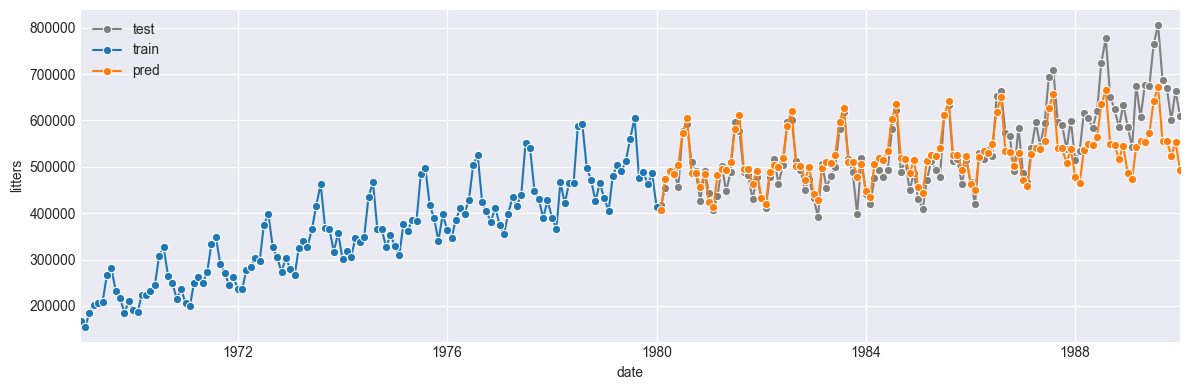

In [89]:
eval_model(data_train, data_test, predictions)

- The SARIMAX from the ForecasterSarimax yields the same result with the SARIMAX from the statmodels

### Backtesting
- Backtesting is used to assess the performance of the SARIMAX model when generating forecasts for the upcoming 12 months on an annual schedule. 
- In this example, the model is trained up to the training data (i.e. from 1969-01-01 to 1980-01-01), predicting values for the subsequent 12 months in the test data (i.e. from 1980-02-01 to 1981-01-01)
    - Similarly, a forecast is generated at the end of each December until the end of the test data with the model is re-fitted models
    - The model is refitted up to 1981-01-01), predicting values for the subsequent 12 months in the test data (i.e. from 1981-02-01 to 1982-01-01)

In [94]:
# Backtest forecaster
# ==============================================================================
from skforecast.model_selection_sarimax import backtesting_sarimax

forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )

metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = df, # entire data include both train & test
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          steps                 = 12,
                          metric                = 'mean_absolute_error',
                          refit                 = True,
                          n_jobs                = "auto",
                          # If suppress_warnings_fit=True warnings generated during fitting will be ignored.
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

print(f"Metric (mean_absolute_error): {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 --

100%|██████████| 10/10 [00:02<00:00,  4.74it/s]

Metric (mean_absolute_error): 19611.236348344453


- The backtracking prediction yields the better result in compare with the model that fitted only in the training data.

MAE: 19611.236


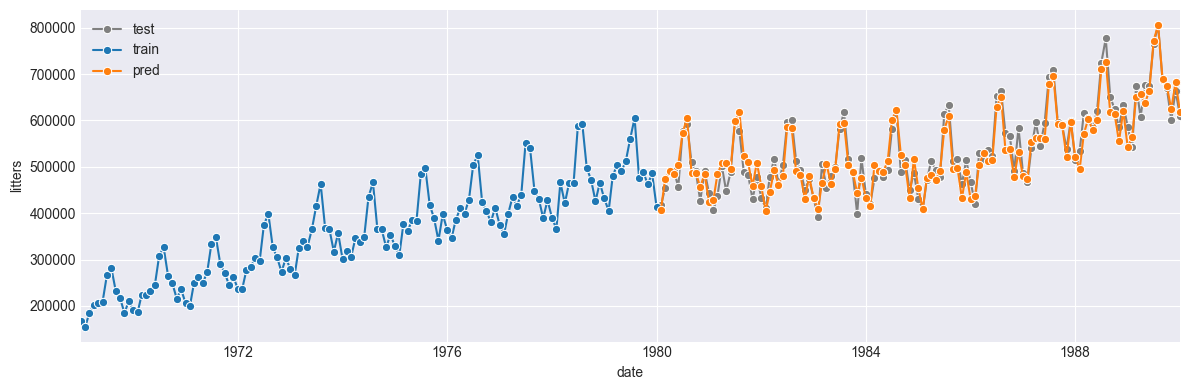

In [99]:
eval_model(data_train, data_test, predictions['pred'])

### Hyper-parameter Tuning
- EDA has successfully narrowed down the search space for the optimal hyperparameters of the model.
- To definitively determine the most appropriate values, the use of strategic search methods:
    - **Method 1 - Statistical Criteria**: Information criterion metrics, such as Akaike's Information Criterion (AIC) or Bayesian Information Criterion (BIC), use different penalties on the maximum likelihood (log-likelihood) estimate of the model as a measure of fit. 
        - Pros: The advantage of using such criteria is that they are computed **only on the training data**, eliminating the need for predictions on new data &#8594; the optimization process is greatly accelerated. 
        - Cons: Information criteria metrics only measure the relative quality of models. This means that all tested models could still be poor fits. Therefore, the final selected model must undergo a backtesting phase. This phase calculates a metric (such as MAE, MSE, MAPE, etc.) that validates its performance on a meaningful scale.
        - The well-known `Auto Arima` algorithm uses this approach.
    - **Method 2 - Validation Techniques**: The use of validation techniques, especially backtesting, is another effective strategy. Backtesting involves evaluating the performance of the model using historical data to simulate real-world conditions. This helps to validate the effectiveness of the hyperparameters under different scenarios, providing a practical assessment of their viability.
        - Pros: the results generated are often more robust, and the metrics derived can provide deeper insights.
        - Cons: more time-consuming, since the model must be trained and then evaluated on new data. 
- Note: Since `Auto Arima` (method 1) is a much faster search strategy, it may be a good option to use it as a first step to identify a set of initial candidate models. 
    - However, because it lacks a business-interpretable metric, it is advisable to compare the final candidates using backtesting

In [100]:
# Train-validation-test data
# ======================================================================================
end_train = '1976-01-01 23:59:59'
end_val = '1984-01-01 23:59:59'

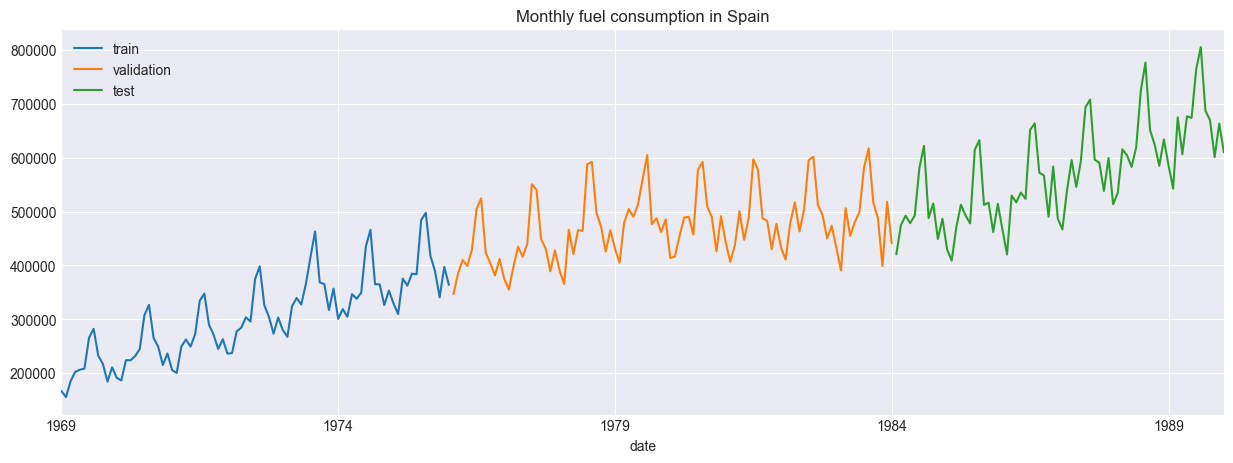

In [102]:
# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(15, 5))
df.loc[:end_train].plot(ax=ax, label='train')
df.loc[end_train:end_val].plot(ax=ax, label='validation')
df.loc[end_val:].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [106]:
# Method 1: auto_arima based on AIC, are compared when forecasting the next three years in batches of 12 months.
from pmdarima import auto_arima

# Auto arima: selection base on AIC
# ==============================================================================
"""
model = auto_arima(
            y                 = df.loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
"""

# It may be of interest to capture the trace generated by the auto_arima function to allow for more comprehensive exploration of the results. 
# The current implementation prints the results, but it is possible to capture and store them in a structured Pandas dataframe.

from io import StringIO
import contextlib

# Capture auto_arima trace in a pandas dataframe
# ==============================================================================
buffer = StringIO()
with contextlib.redirect_stdout(buffer):
    auto_arima(
            y                 = df.loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
trace_autoarima = buffer.getvalue()

In [107]:
pattern = r'ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec'
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(matches, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'm', 'intercept', 'AIC', 'Time'])
results['order'] = results[['p', 'd', 'q']].apply(lambda x: f"({x[0]},{x[1]},{x[2]})", axis=1)
results['seasonal_order'] = results[['P', 'D', 'Q', 'm']].apply(lambda x: f"({x[0]},{x[1]},{x[2]},{x[3]})", axis=1)
results = results[['order', 'seasonal_order', 'intercept', 'AIC', 'Time']]
results.sort_values(by='AIC').reset_index(drop=True)

/var/folders/10/n2pk9skj29l6tsds0vmch5lm0000gn/T/ipykernel_46577/3507919561.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['order'] = results[['p', 'd', 'q']].apply(lambda x: f"({x[0]},{x[1]},{x[2]})", axis=1)
/var/folders/10/n2pk9skj29l6tsds0vmch5lm0000gn/T/ipykernel_46577/3507919561.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['seasonal_order'] = results[['P', 'D', 'Q', 'm']].apply(lambda x: f"({x[0]},{x[1]},{x[2]},{x[3]})", axis=1)


,order,seasonal_order,intercept,AIC,Time
0,"(1,1,1)","(0,1,1,12)",,3834.135,0.29
1,"(2,1,0)","(0,1,1,12)",,3834.277,0.13
2,"(0,1,2)","(0,1,1,12)",,3834.320,0.15
3,"(1,1,1)","(0,1,2,12)",,3835.160,1.04
4,"(1,1,1)","(0,1,1,12)",intercept,3835.455,0.22
5,"(1,1,1)","(1,1,1,12)",,3835.564,0.17
6,"(2,1,1)","(0,1,1,12)",,3836.104,0.31
7,"(1,1,2)","(0,1,1,12)",,3836.107,0.25
8,"(1,1,1)","(1,1,2,12)",,3836.443,1.43
9,"(1,1,0)","(0,1,1,12)",,3836.696,0.09


In [108]:
# Method 2: grid_search_sarimax based on backtesting with a mean absolute error
from skforecast.model_selection_sarimax import grid_search_sarimax


# Grid search based on backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), maxiter=500), # Placeholder replaced in the grid search
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = df.loc[:end_val],
                   param_grid            = param_grid,
                   steps                 = 12,
                   refit                 = True,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = len(data_train),
                   fixed_train_size      = False,
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )

results_grid.head(5)

Number of models compared: 45.


params grid: 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]


,params,mean_absolute_error,order,seasonal_order,trend
16,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897511,"(0, 1, 1)","(1, 1, 1, 12)",n
15,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897511,"(0, 1, 1)","(1, 1, 1, 12)",None
34,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376855,"(1, 1, 1)","(1, 1, 1, 12)",n
33,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376855,"(1, 1, 1)","(1, 1, 1, 12)",None
43,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",20176.735508,"(2, 1, 1)","(1, 1, 1, 12)",n


- The two candidate models used for back-testing: 
    - The one selected by `auto_arima` based on AIC:
        - 'order': `(1,1,1)`, 'seasonal_order': `(0,1,1,12)` as per lowest AIC
    - The one selected by the `grid_search_sarimax` based on backtesting with a mean absolute error
        - 'order': `(0,1,1)`, 'seasonal_order': `(1,1,1,12)` as per lowest MAE

In [112]:
def backtest_candidate_model(df, 
                             end_val, 
                             forecaster):
    metrics, predictions = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = df,
                                initial_train_size    = len(df.loc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )
    return metrics, predictions 

In [113]:
# Backtest predictions with the best model according to auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), maxiter=500),
             )
metric_m1, predictions_m1  = backtest_candidate_model(df, end_val, forecaster)

100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


In [114]:
# Backtest predictions with the best model according to grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
metric_m2, predictions_m2  = backtest_candidate_model(df, end_val,  forecaster)

100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Metric (mean_absolute_error) for auto arima model : 20149.352203806546
Metric (mean_absolute_error) for grid search model: 19803.08072742066


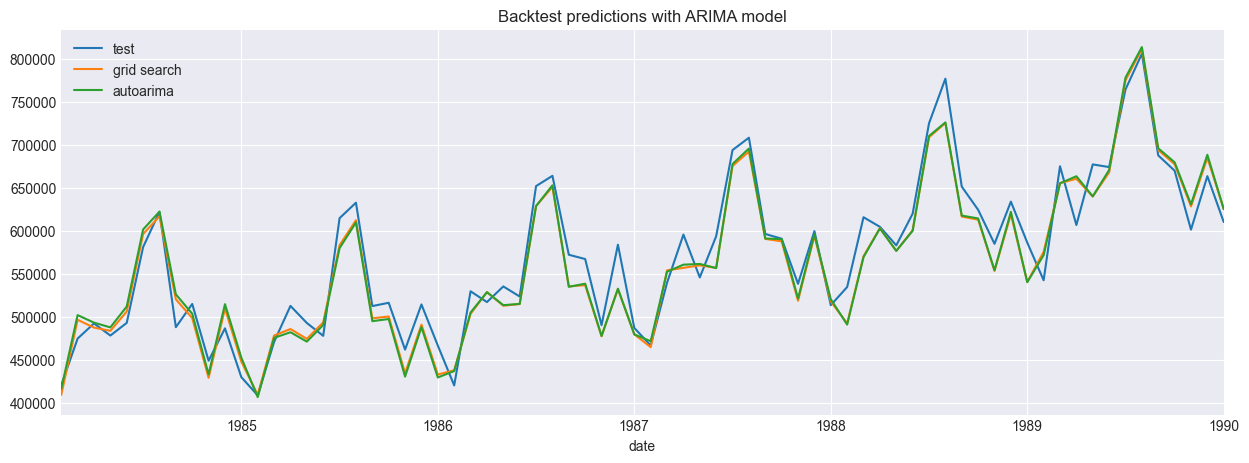

In [116]:
# Compare predictions
# ==============================================================================
print(f"Metric (mean_absolute_error) for auto arima model : {metric_m1}")
print(f"Metric (mean_absolute_error) for grid search model: {metric_m2}")


fig, ax = plt.subplots(figsize=(15, 5))
df.loc[end_val:].plot(ax=ax, label='test')
predictions_m2 = predictions_m2.rename(columns={'pred': 'grid search'})
predictions_m1 = predictions_m1.rename(columns={'pred': 'autoarima'})
predictions_m2.plot(ax=ax)
predictions_m1.plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

- The SARIMAX configuration identified by the grid search technique (based on backtesting with a mean absolute error) gives slightly better results.

### Exogenous Variables
- The implementation of ARIMA-SARIMA(X) offers a valuable feature: the ability to integrate **exogenous variables** as forecasting factors alongside the primary time series under consideration. 
- The addition of exogenous variables is done using the `exog` argument.


## Model Inference
- Forecasting with an ARIMA model becomes challenging when the forecast horizon data does not immediately follow the last observed value during the training phase. 
- This complexity is due to the moving average (MA) component, which relies on past forecast errors as predictors. 
- For this reason, in most cases, ARIMA models are retrained each time predictions need to be made.
- Despite considerable efforts and advances to speed up the training process for these models, it is not always feasible to retrain the model between predictions, either due to time constraints or insufficient computational resources for repeated access to historical data. 
- An intermediate approach is to feed the model with data from the last training observation to the start of the prediction phase.
- For example, imagine a situation where a model was trained 20 days ago with daily data from the past three years. 
    - When generating new predictions, only the 20 most recent values would be needed, rather than the complete historical dataset (365 * 3 + 20).
- `ForecasterSarimax` class simplifies this considerably by automating the process through the `last_window` argument in its `predict` method.

In [117]:
# Split data Train - Last window
# ==============================================================================
end_train = '1980-01-01 23:59:59'
# Train ARIMA forecaster with values from 1969-01-01 to 1980-01-01
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
forecaster.fit(y=df.loc[:end_train])


In [118]:
# Next, 12 new steps are predicted.
# Predict using last window
# ==============================================================================
predictions = forecaster.predict(
                  steps       = 12,
                  last_window = df.loc[end_train:]
              )
predictions.head(3)


1990-02-01    580893.320820
1990-03-01    693624.449220
1990-04-01    654315.472049
Freq: MS, Name: pred, dtype: float64

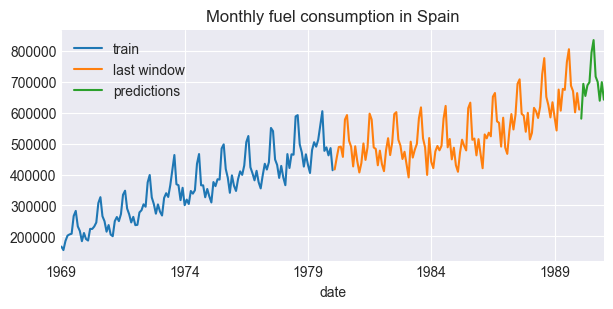

In [119]:
# Plot predictions
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
df.loc[:end_train].plot(ax=ax, label='train')
df.loc[end_train:].plot(ax=ax, label='last window')
predictions.plot(ax=ax, label='predictions')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();